# Clustering - Sleep Labels

This notebook is used to produce results related to clustering of data from the fitbit vitals data loaded from the corresponding pickle files and using sleep efficiency labels to then further find cluster impurities, distrinution and good sleep reciepes

## Importing Required Libraries

In [220]:
# Importing scientific libarires required for analysis and handling data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Importing libraries related to handling of files and directory
import os
import glob
import pickle

# Importing utility functions from the code base
from utils.directory_utils import *
from utils.general_utils import *
from utils.sleep_utils import *
from data_preprocessor.get_user_data import *

# Importing Machine Learning utilities
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose

## Data

This section loads all different types of data from the pickle files that we have saved and then loads the relevant data into numpy array for further analysis

### Heart Rate, Sleep, Calories and Activity Time Series Data

##### Define the paths to the directories that contain the pickle files with the corresponding data

In [46]:
heart_rate_data_directory_path = f'../data/data_files/Saksham/heart/'
heart_rate_ts_data = []
calories_data_directory_path = f'../data/data_files/Saksham/calories/'
calories_ts_data = []
activity_label_ts_data = []
sleep_data_directory_path = f'../data/data_files/Saksham/sleep/'
sleep_effeciency_ratio = []
sleep_stages_summary = []

common_file_nms = get_file_nms(heart_rate_data_directory_path, '*.pickle')
common_file_nms = common_file_nms.intersection(get_file_nms(calories_data_directory_path, '*.pickle'))
common_file_nms = common_file_nms.intersection(get_file_nms(sleep_data_directory_path, '*.pickle'))
len(common_file_nms)

91

##### Load the data from the pickle files into a list

In [50]:
counter = 0
for file_name in common_file_nms:
    heart_rate_file_path = construct_path(heart_rate_data_directory_path, file_name)
    calories_file_path = construct_path(calories_data_directory_path, file_name)
    sleep_file_path = construct_path(sleep_data_directory_path, file_name)
    heart_rate_data_raw = pickle.load(open(heart_rate_file_path, 'rb'))
    heart_rate_data = get_attribute_val_array_by_minute(heart_rate_data_raw, 'value')
    
    calories_data_raw = pickle.load(open(calories_file_path, 'rb'))
    calories_value_ts = get_attribute_val_array_by_minute(calories_data_raw, 'value')
    activity_value_ts = get_attribute_val_array_by_minute(calories_data_raw, 'level')
    sleep_data_raw = pickle.load(open(sleep_file_path, 'rb'))
    if heart_rate_data.shape != (0,) and not np.isnan(heart_rate_data).all():
        if calories_value_ts.shape != (0,) and not np.isnan(calories_value_ts).all():
            try:
                if get_sleep_stages_summary(sleep_data_raw):
                    sleep_stages = get_sleep_stages_summary(sleep_data_raw)
                    sleep_ratio = get_time_asleep_to_time_in_bed_ratio(sleep_data_raw, 'fake_user_id')
                    counter += 1
                    
                    heart_rate_ts_data.append(heart_rate_data)
                    calories_ts_data.append(calories_value_ts)
                    activity_label_ts_data.append(activity_value_ts)
                    sleep_effeciency_ratio.append(sleep_ratio)
                    sleep_stages_summary.append(sleep_stages)
            except:
                print(file_name)

2018-11-22.pickle


##### Convert the lists into the correct format: array and dataframe

In [61]:
heart_rate_ts_data = np.array(heart_rate_ts_data)
calories_ts_data, activity_label_ts_data = np.array(calories_ts_data), np.array(activity_label_ts_data)
sleep_effeciency_ratio, sleep_stages_summary = np.array(sleep_effeciency_ratio), pd.DataFrame(list(sleep_stages_summary))

In [67]:
# Check for the shape of all the arrays and dataframes
heart_rate_ts_data.shape, calories_ts_data.shape, activity_label_ts_data.shape, sleep_effeciency_ratio.shape, sleep_stages_summary.shape

((68, 1440), (68, 1440), (68, 1440), (68,), (68, 4))

In [68]:
# Make sure activity value does not have a nan field (not sure how we would fill this)
np.isnan(activity_value_ts).any()

False

In [69]:
# Remove nans from heart and calories data
heart_rate_ts_data = remove_nans_from_array(heart_rate_ts_data)
calories_ts_data = remove_nans_from_array(calories_ts_data)

In [70]:
# Check that no nans in any of the data
np.isnan(heart_rate_ts_data).any(), np.isnan(calories_ts_data).any()

(False, False)

### Heart Rate and Calories Trends

This section will essentially find the trends from the original data

In [74]:
trend_window_length = 15

#### Heart Trends

In [77]:
heart_trends = []
for day in heart_rate_ts_data:
    result = seasonal_decompose(day, model='additive', freq=trend_window_length, extrapolate_trend='freq')
    heart_trends.append(result.trend)
heart_trends = np.array(heart_trends)
heart_trends = remove_nans_from_array(heart_trends)
# Make sure the shape is same and there are no nan values
heart_trends.shape, np.isnan(heart_trends).any()

((68, 1440), False)

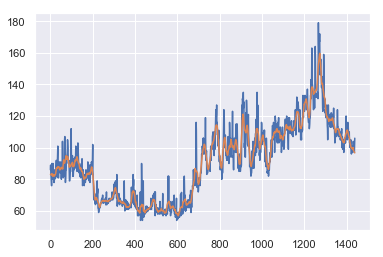

In [81]:
# plotting heart trends to asses the fit to the overall data
plt.plot(heart_rate_ts_data[0, :])
plt.plot(heart_trends[0, :])

#### Calories Trends

In [79]:
calories_trends = []
for day in calories_ts_data:
    result = seasonal_decompose(day, model='additive', freq=trend_window_length, extrapolate_trend='freq')
    calories_trends.append(result.trend)
calories_trends = np.array(calories_trends)
calories_trends = remove_nans_from_array(calories_trends)
# Make sure the shape is same and there are no nan values
calories_trends.shape, np.isnan(calories_trends).any()

((68, 1440), False)

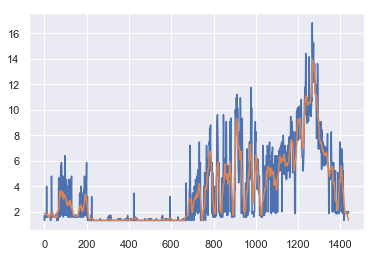

In [80]:
# plotting caloires trends to asses the fit to the overall data
plt.plot(calories_ts_data[0, :])
plt.plot(calories_trends[0, :])

### Dimensionality Reduction

This section will reduce the dimensions of the arrays so that we can easily apply different clustering techniques on them

In [82]:
mean_window_length = 15

In [84]:
# Reduce the dimension of the arrays
reduced_heart_trends = reduce_time_series_dimension(heart_trends, mean_window_length)
reduced_calories_trends = reduce_time_series_dimension(calories_trends, mean_window_length)
# Check for the shape of the arrays
reduced_heart_trends.shape, reduced_calories_trends.shape

((68, 96), (68, 96))

## Sleep Labels

In this section of the notebook we try to find the optimal boundary for constructing the sleep labels using different techniques

Text(0.5, 1.0, 'Sleep Efficiency Histogram')

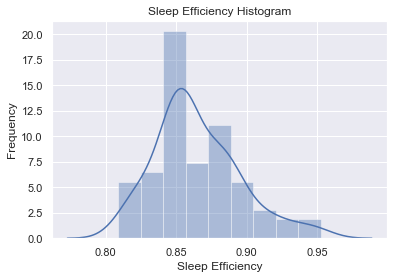

In [93]:
# Constructing a histogram plot for the sleep efficiency ratio.
# Sleep Efficiency Ratio is found as total_time_asleep / total_time_in_bed
sns.distplot(sleep_effeciency_ratio)
plt.xlabel('Sleep Efficiency')
plt.ylabel('Frequency')
plt.title('Sleep Efficiency Histogram')

Text(0.5, 1.0, 'Minutes in Deep Sleep Histogram')

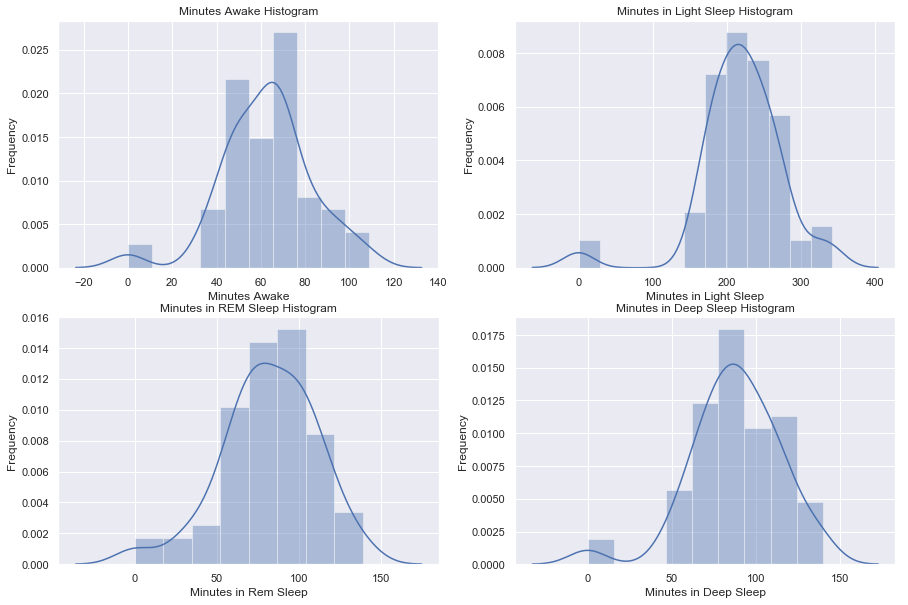

In [109]:
# Constructing a histogram plot for the different sleep stages.
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(sleep_stages_summary['wake'], ax = ax[0, 0])
ax[0, 0].set_xlabel('Minutes Awake')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('Minutes Awake Histogram')

sns.distplot(sleep_stages_summary['light'], ax = ax[0, 1])
ax[0, 1].set_xlabel('Minutes in Light Sleep')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('Minutes in Light Sleep Histogram')

sns.distplot(sleep_stages_summary['rem'], ax = ax[1, 0])
ax[1, 0].set_xlabel('Minutes in Rem Sleep')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('Minutes in REM Sleep Histogram')

sns.distplot(sleep_stages_summary['deep'], ax = ax[1, 1])
ax[1, 1].set_xlabel('Minutes in Deep Sleep')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('Minutes in Deep Sleep Histogram')

In [154]:
final_sleep_labels = sleep_effeciency_ratio > 0.85

## Activity Percentages

In this section of the notebook we aggregate the activity labels of a person from minute level to percentage level

In [222]:
activity_percentages = activity_percentage_finder(activity_label_ts_data)
activity_percentages.shape

(68, 4)

Text(0.5, 1.0, '% High Activity Histogram')

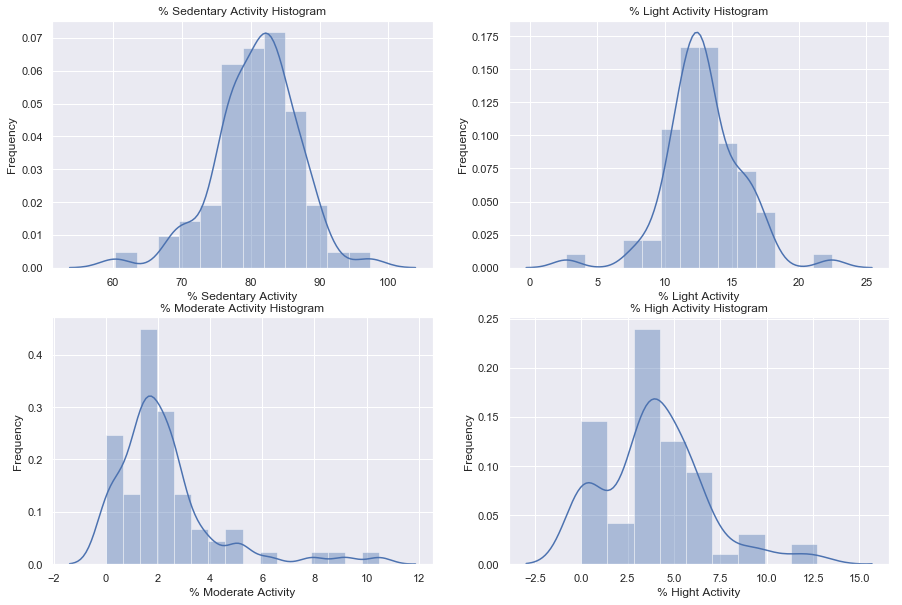

In [226]:
# Constructing a histogram plot for the different activity level percentages.
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[:, 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[:, 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[:, 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[:, 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Hight Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% High Activity Histogram')

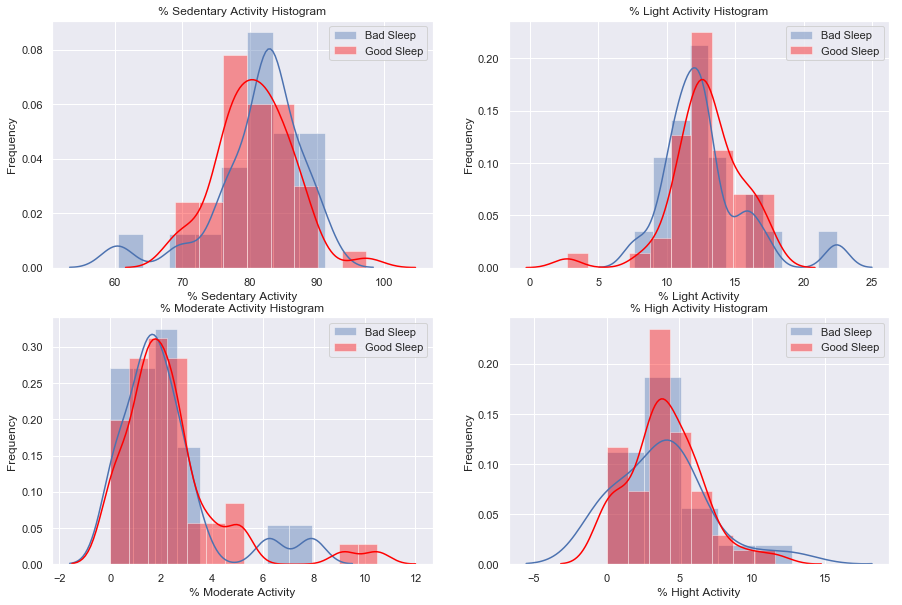

In [238]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[~final_sleep_labels, 0], ax = ax[0, 0], label='Bad Sleep')
sns.distplot(activity_percentages[final_sleep_labels, 0], ax = ax[0, 0], color='red', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[~final_sleep_labels, 1], ax = ax[0, 1], label='Bad Sleep')
sns.distplot(activity_percentages[final_sleep_labels, 1], ax = ax[0, 1], color='red', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[~final_sleep_labels, 2], ax = ax[1, 0], label='Bad Sleep')
sns.distplot(activity_percentages[final_sleep_labels, 2], ax = ax[1, 0], color='red', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[~final_sleep_labels, 3], ax = ax[1, 1], label='Bad Sleep')
sns.distplot(activity_percentages[final_sleep_labels, 3], ax = ax[1, 1], color='red', label='Good Sleep')
ax[1, 1].set_xlabel('% Hight Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% High Activity Histogram')
ax[1, 1].legend()

## Clustering

In this section of the notebook we apply different clustering techniques on the data that we have got and see what are the different recipes

In [117]:
num_master_clusters = 4
num_activity_clusters = 8

### K-Means - Euclidean

Here we apply K-Means on the data with euclidean (L-2 Norm) as the distance metric

#### Fitting the Model

In [133]:
kmeans_mod = KMeans(n_clusters=num_master_clusters)
kmeans_mod.fit(reduced_heart_trends)
cluster_assignments = kmeans_mod.predict(reduced_heart_trends)
np.unique(cluster_assignments, return_counts=True)

(array([0, 1, 2, 3]), array([21, 23, 14, 10], dtype=int64))

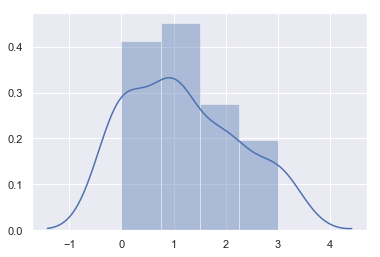

In [134]:
# Visualizing the number of points in each cluster
sns.distplot(cluster_assignments)

#### Visualization of Clusters

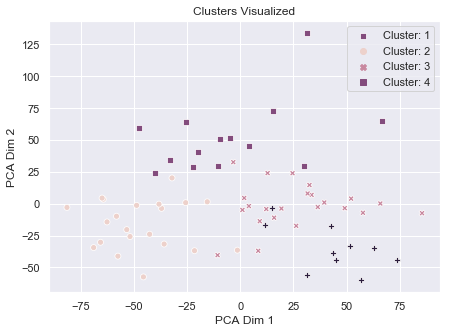

In [152]:
# Simple Cluster Visualization
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
plt.figure(figsize=(7, 5))
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=cluster_assignments, style=cluster_assignments)
plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.title('Clusters Visualized')
plt.legend([f'Cluster: {i+1}' for i in range(4)])

Text(0.5, 1.0, 'Clusters Visualized')

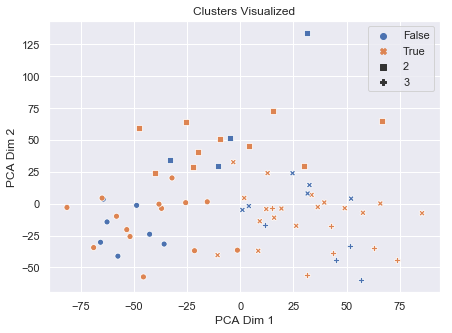

In [162]:
# Cluster Visualization based on Sleep Efficiency
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(reduced_heart_trends)
plt.figure(figsize=(7, 5))
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=final_sleep_labels, style=cluster_assignments)
plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.title('Clusters Visualized')

#### Cluster Purity

Finding cluster purity based on the sleep labels

In [174]:
# Clustering Purity is defined by ratio of dominant class of sleep label instance in the cluster 
# to total number of instances in the cluster
for master_cluster_num in range(num_master_clusters):
    cluster_sleep_labels = final_sleep_labels[cluster_assignments == master_cluster_num]
    pos_sleep_label_purity = sum(cluster_sleep_labels) / cluster_sleep_labels.shape[0]
    print(f'Cluster Number: {master_cluster_num}, Purity:', max(pos_sleep_label_purity, 1 - pos_sleep_label_purity))

Cluster Number: 0, Purity: 0.6666666666666666
Cluster Number: 1, Purity: 0.7391304347826086
Cluster Number: 2, Purity: 0.7142857142857143
Cluster Number: 3, Purity: 0.6


Text(0.5, 1.0, 'Cluster 4')

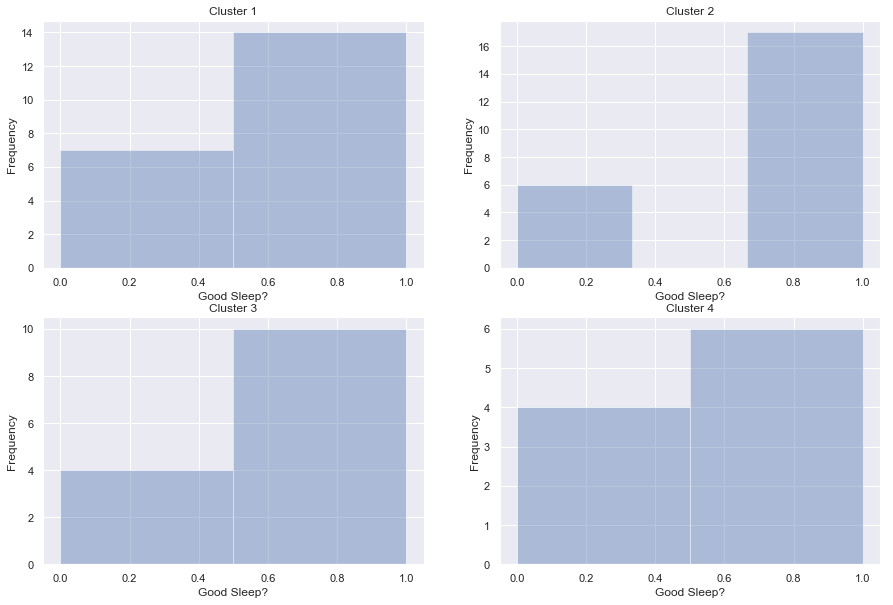

In [224]:
# Constructing a histogram plot for visualizing the sleep efficiency cluster purity in all cluster.
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(np.array(final_sleep_labels[cluster_assignments==0], dtype=np.int16), ax = ax[0, 0], kde=False)
ax[0, 0].set_xlabel('Good Sleep?')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('Cluster 1')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==1], dtype=np.int16), ax = ax[0, 1], kde=False)
ax[0, 1].set_xlabel('Good Sleep?')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('Cluster 2')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==2], dtype=np.int16), ax = ax[1, 0], kde=False)
ax[1, 0].set_xlabel('Good Sleep?')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('Cluster 3')

sns.distplot(np.array(final_sleep_labels[cluster_assignments==3], dtype=np.int16), ax = ax[1, 1], kde=False)
ax[1, 1].set_xlabel('Good Sleep?')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('Cluster 4')

#### Activity Histograms for Clusters

#### Cluster: 1

Text(0.5, 1.0, '% High Activity Histogram')

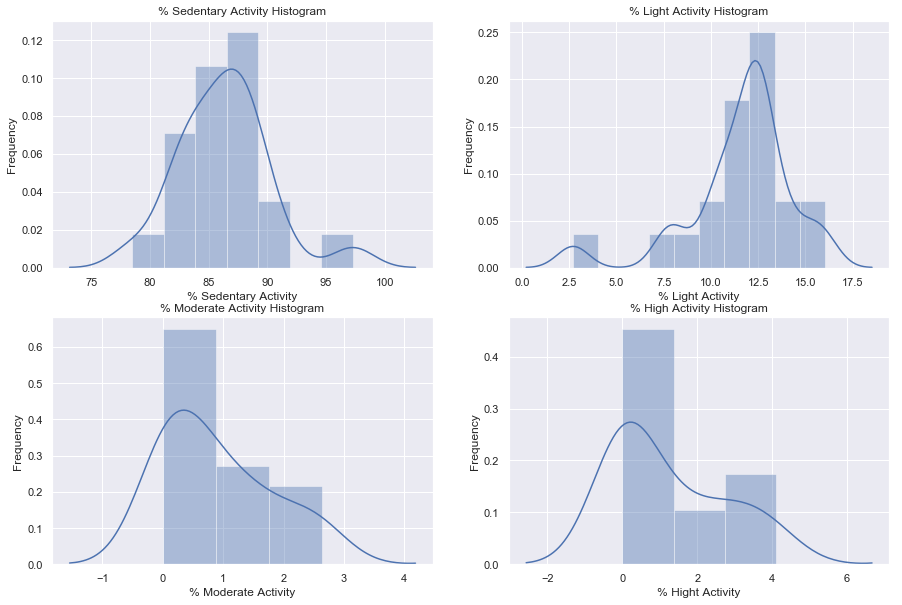

In [242]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==0), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==0), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Hight Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% High Activity Histogram')

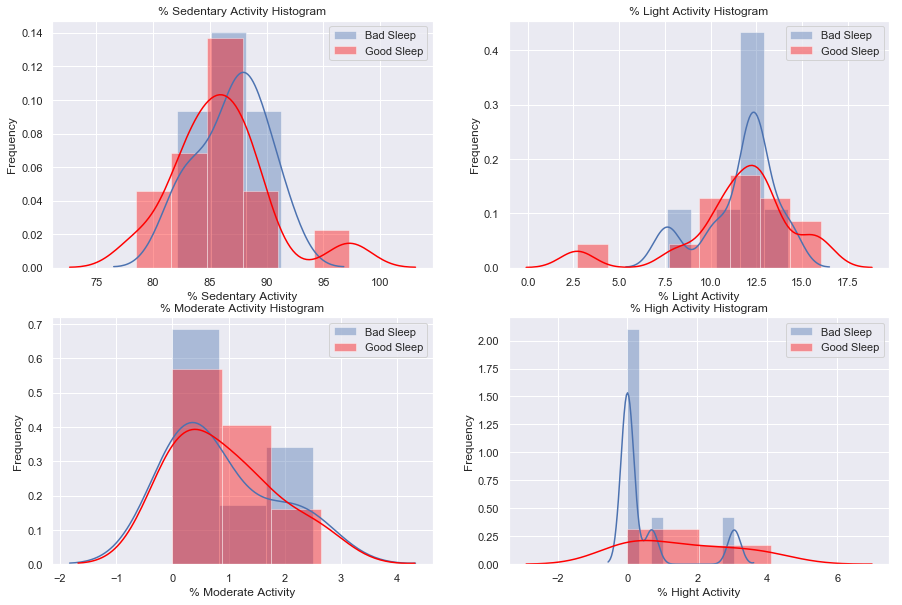

In [239]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 0], ax = ax[0, 0], label='Bad Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 1], ax = ax[0, 1], label='Bad Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 2], ax = ax[1, 0], label='Bad Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==0) & (~final_sleep_labels), 3], ax = ax[1, 1], label='Bad Sleep')
sns.distplot(activity_percentages[(cluster_assignments==0) & (final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Good Sleep')
ax[1, 1].set_xlabel('% Hight Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% High Activity Histogram')
ax[1, 1].legend()

#### Cluster: 2

Text(0.5, 1.0, '% High Activity Histogram')

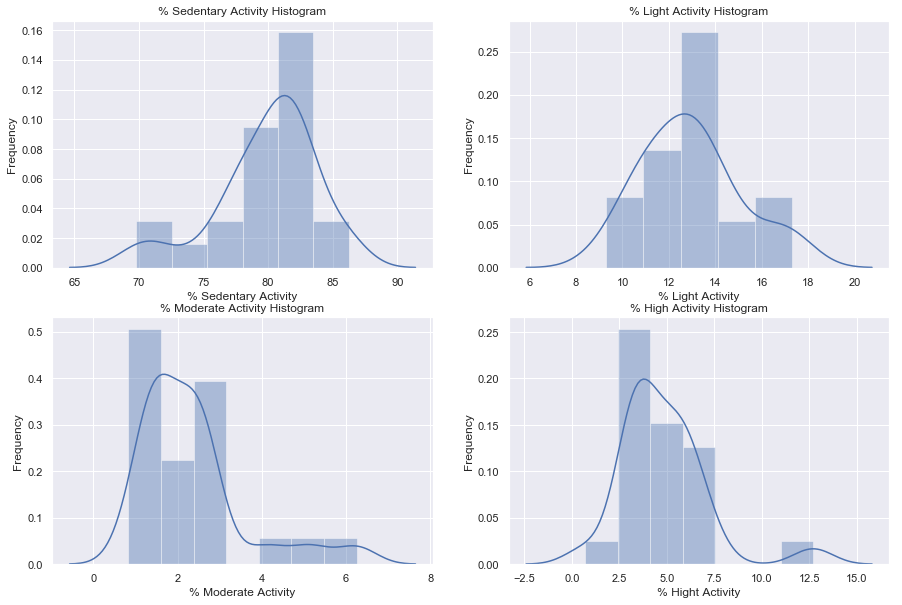

In [243]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==1), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==1), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Hight Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% High Activity Histogram')

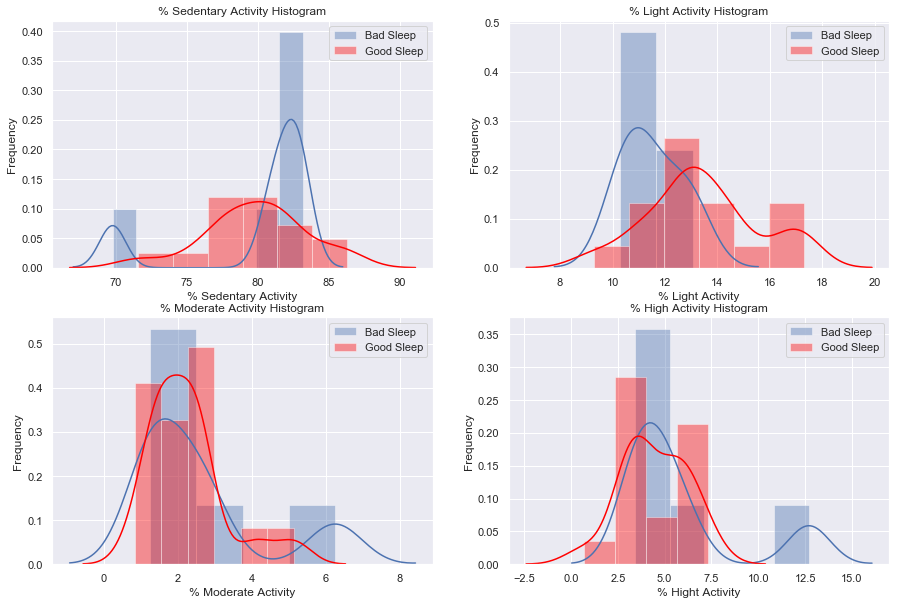

In [244]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 0], ax = ax[0, 0], label='Bad Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 1], ax = ax[0, 1], label='Bad Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 2], ax = ax[1, 0], label='Bad Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==1) & (~final_sleep_labels), 3], ax = ax[1, 1], label='Bad Sleep')
sns.distplot(activity_percentages[(cluster_assignments==1) & (final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Good Sleep')
ax[1, 1].set_xlabel('% Hight Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% High Activity Histogram')
ax[1, 1].legend()

#### Cluster: 3

Text(0.5, 1.0, '% High Activity Histogram')

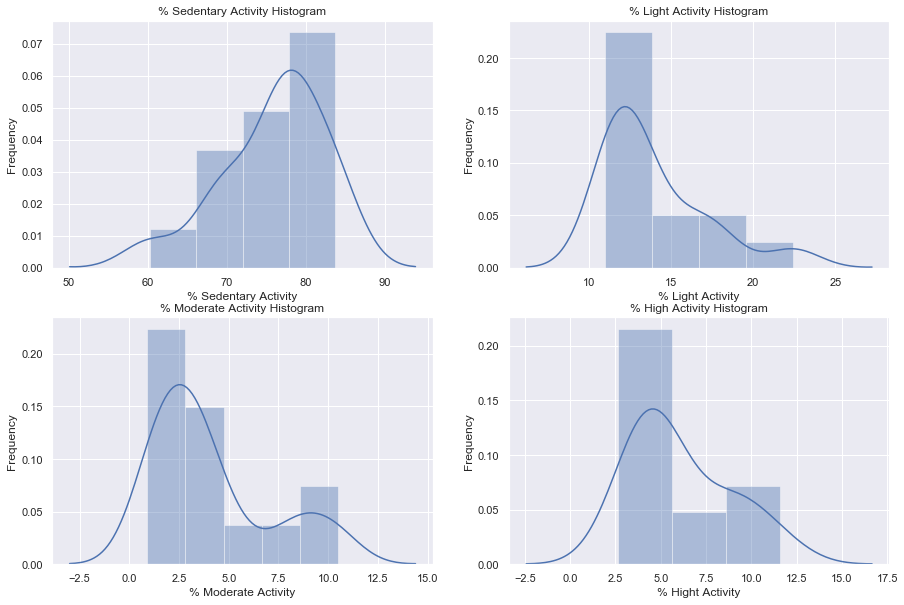

In [245]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==2), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==2), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Hight Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% High Activity Histogram')

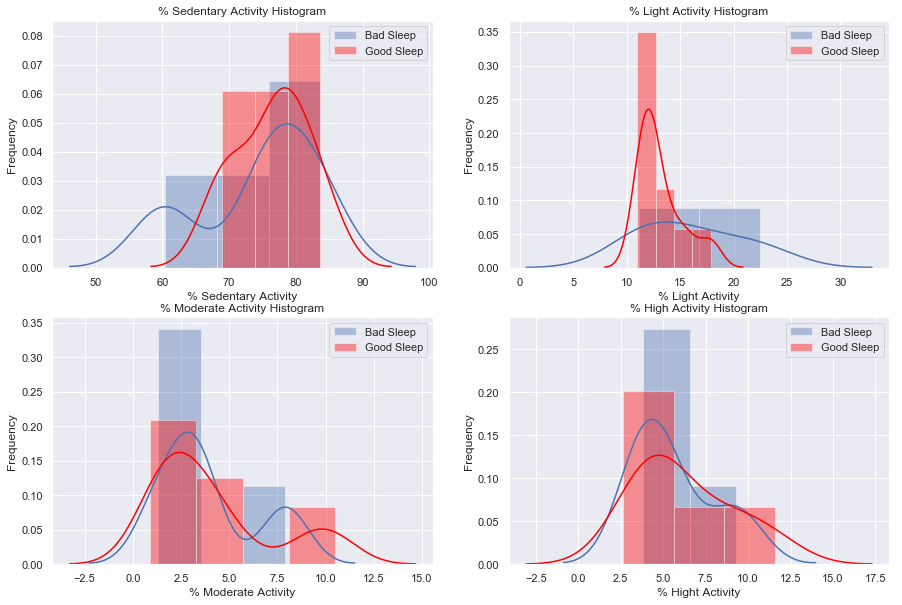

In [246]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 0], ax = ax[0, 0], label='Bad Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 1], ax = ax[0, 1], label='Bad Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 2], ax = ax[1, 0], label='Bad Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==2) & (~final_sleep_labels), 3], ax = ax[1, 1], label='Bad Sleep')
sns.distplot(activity_percentages[(cluster_assignments==2) & (final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Good Sleep')
ax[1, 1].set_xlabel('% Hight Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% High Activity Histogram')
ax[1, 1].legend()

#### Cluster: 4

Text(0.5, 1.0, '% High Activity Histogram')

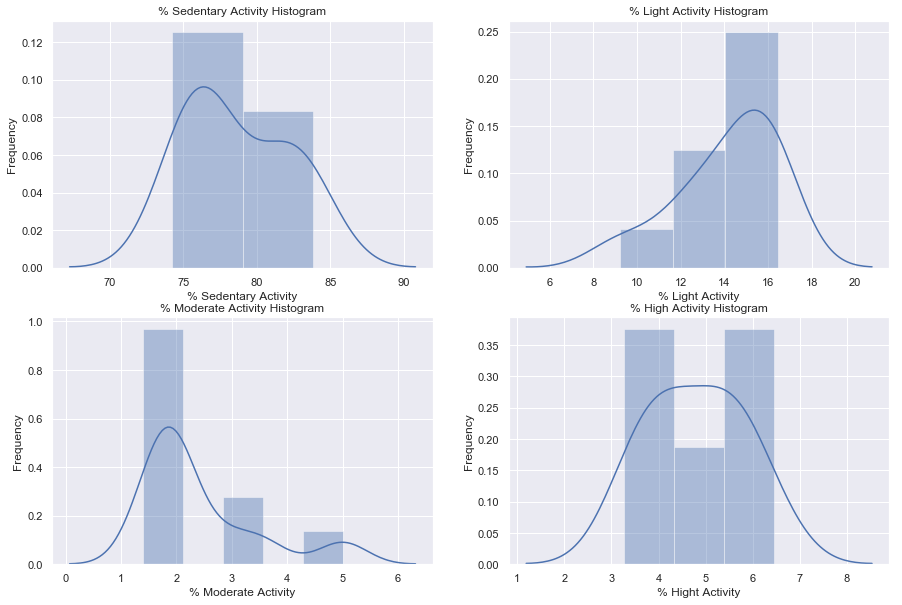

In [247]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==3), 0], ax = ax[0, 0])
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 1], ax = ax[0, 1])
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 2], ax = ax[1, 0])
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')

sns.distplot(activity_percentages[(cluster_assignments==3), 3], ax = ax[1, 1])
ax[1, 1].set_xlabel('% Hight Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% High Activity Histogram')

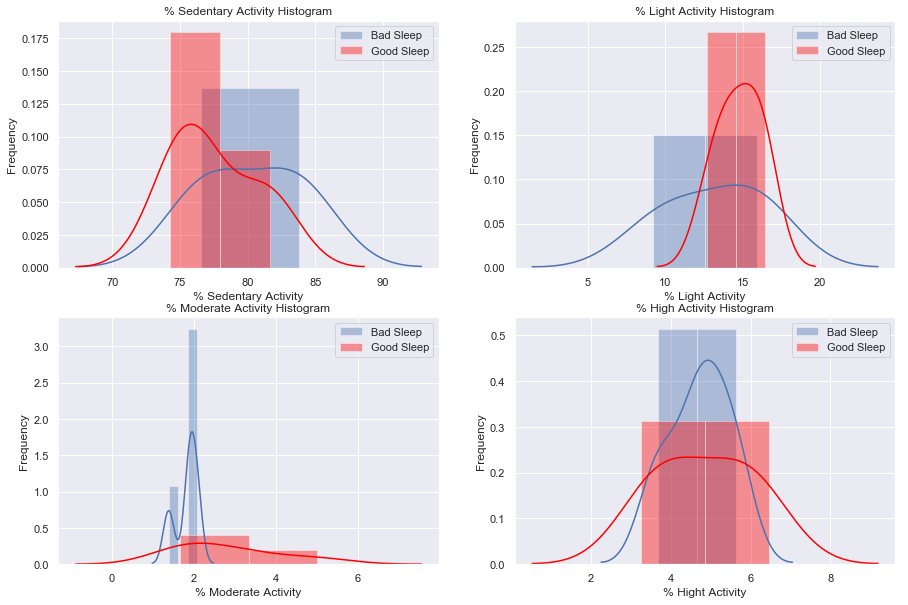

In [248]:
# Constructing a histogram plot for the different activity level percentages visualizing with respect to the good sleep label
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 0], ax = ax[0, 0], label='Bad Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 0], ax = ax[0, 0], color='red', label='Good Sleep')
ax[0, 0].set_xlabel('% Sedentary Activity')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('% Sedentary Activity Histogram')
ax[0, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 1], ax = ax[0, 1], label='Bad Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 1], ax = ax[0, 1], color='red', label='Good Sleep')
ax[0, 1].set_xlabel('% Light Activity')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('% Light Activity Histogram')
ax[0, 1].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 2], ax = ax[1, 0], label='Bad Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 2], ax = ax[1, 0], color='red', label='Good Sleep')
ax[1, 0].set_xlabel('% Moderate Activity')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].set_title('% Moderate Activity Histogram')
ax[1, 0].legend()

sns.distplot(activity_percentages[(cluster_assignments==3) & (~final_sleep_labels), 3], ax = ax[1, 1], label='Bad Sleep')
sns.distplot(activity_percentages[(cluster_assignments==3) & (final_sleep_labels), 3], ax = ax[1, 1], color='red', label='Good Sleep')
ax[1, 1].set_xlabel('% Hight Activity')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].set_title('% High Activity Histogram')
ax[1, 1].legend()

#### Sub-Clustering on Activity Data

In [ ]:
cluster_0_activity_percentages = activity_percentages[cluster_assignments == 0
cluster

#### K-Means - DTW

In [19]:
%%time
clusterer = TimeSeriesKMeans(4, metric='dtw', max_iter=10)
cluster_assignments = clusterer.fit_predict(reduced_heart_trends[:, :])
np.unique(cluster_assignments, return_counts=True)

2633.180 --> 1910.910 --> 1878.195 --> 1878.195 --> 
Wall time: 17.8 s


In [20]:
np.unique(cluster_assignments, return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([17, 22, 13, 17], dtype=int64))

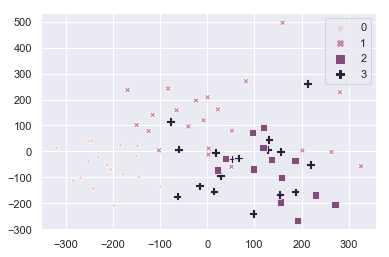

In [21]:
pca_mod = PCA(2)
pca_heart = pca_mod.fit_transform(heart_trends)
sns.scatterplot(pca_heart[:, 0], pca_heart[:, 1], hue=cluster_assignments, style=cluster_assignments, size=cluster_assignments)